# NumPy

Remember the numpy array? It's the basic data type used by numpy to do the things it does quickly.

In [1]:
import numpy as np # By convention we import it as "np"

# Here's a list
data_list = [2, 4, 6, 8, 10]
print "As list: ", data_list

# Now it's an array
data_array = np.array(data_list)
print "As array: ", data_array

As list:  [2, 4, 6, 8, 10]
As array:  [ 2  4  6  8 10]


The `np.arange()` function is often a nice way to create an array, too.

In [2]:
print np.arange(12) # start from zero, go up to (but not including) argument
print np.arange(2, 12) # start from first argument, go up to (but not including) second argument
print np.arange(2, 12, 2) # start, end, step

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 2  3  4  5  6  7  8  9 10 11]
[ 2  4  6  8 10]


# matplotlib

Made by people who thought MATLAB had a plotting system worth copying.

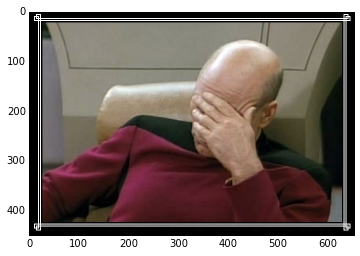

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

reaction = mpimg.imread('picard.png')
imgplot = plt.imshow(reaction)

In matplotlib, an axis is not an axis. Well, an "Axes" isn't (aren't?) axes. An "Axes" is what most people would call a graph or plot.

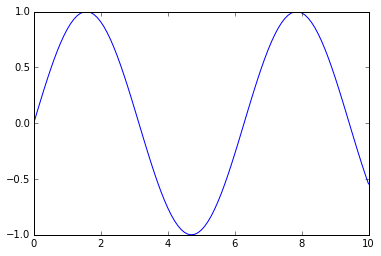

In [4]:
x = np.arange(0, 10.1, 0.1)
y = np.sin(x)

plt.figure()
axes = plt.axes()
axes.plot(x, y)

You can set up multiple plots in the same figure with the `subplots()` function.

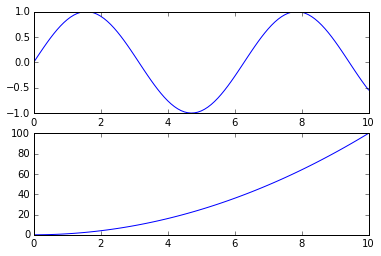

In [5]:
y2 = x ** 2

fig, axes = plt.subplots(2, 1) # 2 rows, 1 column - axes is a list of the plots (same dimensions as the figure)
axes[0].plot(x, y)
axes[1].plot(x, y2)

Repeated `plot()` commands append things to the existing graph.

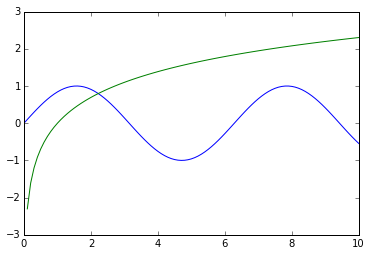

In [6]:
plt.figure()

# Plot called directly puts things on the "current" axis
# Be careful, it's easy to put them in the wrong place
plt.plot(x, y)
y3 = np.log(x[1:]) # skip zero for log()
plt.plot(x[1:], y3)

We can make our graphs look a bit less like MATLAB by setting the style with `style.use()`.

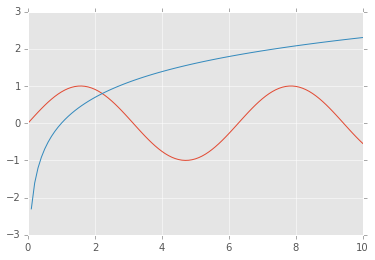

In [7]:
plt.style.use('ggplot')

plt.figure()
plt.plot(x, y)
plt.plot(x[1:], y3)

# Cell Types database

Now we have some tools to start exploring the Cell Types database. The AllenSDK is a set of tools that make interacting with the Cell Types database programmatically easier to do.

Let's start by looking at electrophysiology data from a recorded cell. We'll assume we have already downloaded the Neurodata Without Borders (.nwb) file with the cell's data.

In [8]:
from allensdk.core.nwb_data_set import NwbDataSet
nwb_filename = "464212181.nwb" # Could use the API instead of already having it downloaded
data_set = NwbDataSet(nwb_filename)

Now we have our `data_set` object that has some functions we can use to access the injected current stimulus waveform and the voltage response waveform. We'll pull them out and plot them.

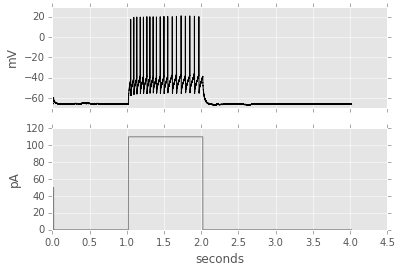

In [9]:
sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)

i = sweep_data["stimulus"] # in A
v = sweep_data["response"] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")

Getting that information out is something we'll want to do a lot, so let's make a function that will do it for whatever sweep we give it, and try it out on some new sweeps.

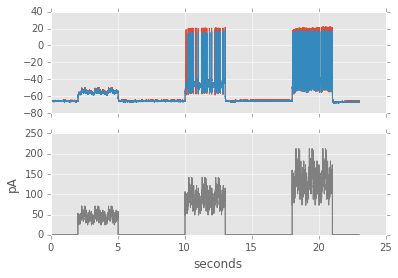

In [10]:
def get_sweep_v_i_t_from_set(data_set, sweep_number):
    sweep_data = data_set.get_sweep(sweep_number)
    i = sweep_data["stimulus"] # in A
    v = sweep_data["response"] # in V
    i *= 1e12 # to pA
    v *= 1e3 # to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    return v, i, t

sweep_numbers = [38, 40]
fig, axes = plt.subplots(2, 1, sharex=True)

for s in sweep_numbers:
    v, i, t = get_sweep_v_i_t_from_set(data_set, s)
    axes[0].plot(t, v)
    axes[1].plot(t, i, color='gray')

axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")

The cell types database also contains 3D reconstructions of neuronal morphologies. The data are presented in the SWC format. We'll download a particular cell's reconstrution here.

In [11]:
# Quick look at the cell's morphology

from allensdk.api.queries.cell_types_api import CellTypesApi

ct = CellTypesApi()

cells = ct.list_cells(require_reconstruction=True)
print "Cells with reconstructions: ", len(cells)

cell_id = 464212183
swc_filename = "reconstruction.swc"
ct.save_reconstruction(cell_id, swc_filename)

Cells with reconstructions:  73


The AllenSDK contains a module that makes it easier to work with the SWC files. We'll see how the data is contained in the file by looking at the first node.

In [12]:
import allensdk.core.swc as swc

morphology = swc.read_swc(swc_filename)
print morphology
compartment_list = morphology.compartment_list
print compartment_list[0]

{'parent': '-1', 'children': ['2', '1827', '1037', '2637'], 'radius': 5.9088, 'y': 343.3144, 'x': 444.3296, 'z': 48.72, 'type': 1, 'id': '1'}


Note that the `type` field refers to the type of neuronal compartment. The values can be `1` for the soma, `2` for the axon, `3` for dendrites, and `4` for apical dendrites (if present).

We can use this data to draw lines between each node and all its children to get a drawing of the cell. We'll do it looking at it from the front and from the side.

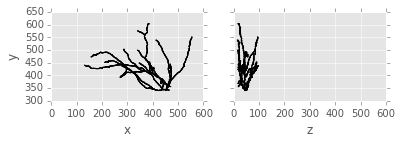

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box-forced')
axes[1].set_aspect('equal', 'box-forced')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    child_nodes = [c for c in morphology.compartment_list if c['id'] in n['children']] 
    for c in child_nodes:
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')

Plotting the data is great, but if we want to do some analysis on things like spike times, spike shapes, etc., we want to go through and extract these features from our raw data. This can be accomplished by using the feature extraction tools in the SDK.

In [14]:
from allensdk.ephys.feature_extractor import EphysFeatureExtractor

sweep_number = 35

v, i, t = get_sweep_v_i_t_from_set(data_set, sweep_number)

fx = EphysFeatureExtractor()

stim_start = 1.0
stim_duration = 1.0

fx.process_instance("", v, i, t, stim_start, stim_duration, "")
feature_data = fx.feature_list[0].mean
print "Avg spike width: {:.2f} ms".format(feature_data['width'])
print "Avg spike threshold: {:.1f} mV".format(feature_data["threshold"])


Avg spike width: 0.93 ms
Avg spike threshold: -35.6 mV


We can take a look at all the properties calculated for a given spike.

In [15]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(feature_data["spikes"][0])

{ 'downstroke': -114.58815026547136,
  'downstroke_i': 210.0,
  'downstroke_idx': 205802,
  'downstroke_t': 1.02901,
  'downstroke_v': -7.9375001774169549,
  'f_fast_ahp': -55.500001240521698,
  'f_fast_ahp_i': 210.0,
  'f_fast_ahp_t': 1.0306000000000002,
  'f_fast_ahp_v': -55.500001240521698,
  'f_peak': 18.156250405823823,
  'f_peak_i': 210.0,
  'f_peak_t': 1.02868,
  'f_slow_ahp': -49.812501113396166,
  'f_slow_ahp_t': 1.0336800000000002,
  'f_slow_ahp_time': 0.40799673602611697,
  'f_trough': -55.500001240521698,
  'half_height_width': 0.00059500000000012321,
  'peak_idx': 205736,
  'rise_time': 0.00055999999999989392,
  't': 1.0281100000000001,
  't_idx': 205622,
  't_idx_n30': 205666,
  't_n30': 1.0283300000000002,
  'thresh_ramp': 60.584564019287804,
  'threshold': -40.781250911531991,
  'threshold_i': 210.0,
  'threshold_idx': 205622,
  'threshold_t': 1.0281100000000001,
  'threshold_v': -40.781250911531991,
  'trough_i': 210.0,
  'trough_idx': 206120,
  'trough_t': 1.030600000

A list comprehension is an easy way to pull out the spike times. 

In [16]:
spike_times = [s["t"] for s in feature_data["spikes"]]

print spike_times[:5] 

[1.0281100000000001, 1.0409350000000002, 1.0536750000000001, 1.0686450000000001, 1.082835]


(0.9, 1.2)

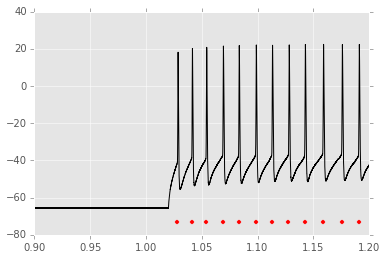

In [17]:
plt.figure()
plt.plot(t, v, color='black')

min_v = v.min()

min_v -= 5.0

plt.scatter(spike_times, np.ones(len(spike_times)) * min_v, c='r')
plt.xlim(0.9, 1.2)

## GLIF models

To use the models in the Cell Types database, we'll use another set of tools in the SDK. Here's how to download and run a particular GLIF model that we know the ID of.

In [18]:
from allensdk.api.queries.glif_api import GlifApi
from allensdk.model.glif.glif_neuron import GlifNeuron
import allensdk.core.json_utilities as json_utilities

glif_model_id = 472299313 # Level 5 GLIF
glif_api = GlifApi()

glif_api.get_neuronal_model(glif_model_id)
neuron_config = glif_api.get_neuron_config()
neuron = GlifNeuron.from_dict(neuron_config)

sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)
i = sweep_data["stimulus"]
sampling_rate = sweep_data["sampling_rate"]
neuron.dt = 1.0 / sampling_rate
index_range = sweep_data["index_range"]

output = neuron.run(i[index_range[0]:index_range[1]])

['ALL', 'COUNT', 'CRITERIA', 'DEBUG', 'EQ', 'EXCEPT', 'FALSE', 'INCLUDE', 'IS', 'MODEL', 'NUM_ROWS', 'ONLY', 'OPTIONS', 'ORDER', 'PIPE', 'PREVIEW', 'SERVICE', 'START_ROW', 'TABULAR', 'TRUE', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_log', 'annotated_section_data_sets_endpoint', 'api_url', 'atlas_image_download_endpoint', 'build_query_url', 'build_schema_query', 'cache_stimulus_file', 'compound_annotated_section_data_sets_endpoint', 'construct_well_known_file_download_url', 'debug_clause', 'default_api_url', 'default_working_directory', 'do_query', 'do_rma_query', 'download_url', 'ephys_sweeps', 'filter', 'filters', 'get_ephys_sweeps', 'get_neuron_config', 'get_neuronal_model', 'get_schema', 'grid_data_endpoint', 'image_to_atlas_endpoint', 'image_to_image_2d_endpoint', 'image_to

We can take a look at the different outputs from the model.

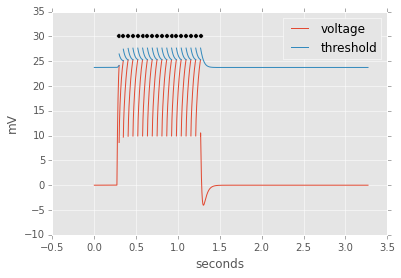

In [19]:
t = np.arange(0, len(output['voltage'])) * neuron.dt

plt.figure()
plt.plot(t, output['voltage'] * 1e3, label='voltage')
plt.plot(t, output['threshold'] * 1e3, label='threshold')
plt.legend()

spike_times = output['interpolated_spike_times']
plt.scatter(spike_times, np.ones(len(spike_times)) * 30.0, c='k')

plt.ylabel("mV")
plt.xlabel("seconds")

## Biophysical models

A biophysical model can be downloaded and run in a similar way, assuming you have NEURON installed and configured correctly.

In [ ]:
from allensdk.api.queries.biophysical_perisomatic_api import BiophysicalPerisomaticApi

bp_api = BiophysicalPerisomaticApi()
bp_api.cache_stimulus = False # don't download the stimulus waveforms (NWB file)
neuronal_model_id = 473863035
bp_api.cache_data(neuronal_model_id, working_directory='neuronal_model')

We need to compile the .mod files that describe the biophysical mechanisms before using the model.

In [ ]:
import os
os.chdir('neuronal_model')
!nrnivmodl modfiles

Welcome back. Let's see what else is in the folder.

In [ ]:
!ls

Now that we have our files sorted, we'll configure the model.

In [ ]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical_perisomatic.utils import Utils

description = Config().load("manifest.json")
utils = Utils(description) # object for setting up the model

manifest = description.manifest
morphology_path = manifest.get_path("MORPHOLOGY")
utils.generate_morphology(morphology_path)
utils.load_cell_parameters()

# Now let's set up the stimulus
h = utils.h # get access to the NEURON environment through "h"
stim = h.IClamp(h.soma[0](0.5)) # insert a current clamp stimulus in the middle of the soma
stim.amp = 0.2 # nA
stim.dur = 1000 # ms
stim.delay = 1000 # ms

# set up variable time step for faster execution
h.cvode_active(1)
h.cvode.atolscale("cai", 1e-4)
h.cvode.maxstep(10)

vec = utils.record_values() # save the voltage and time values

h.tstop = 3000 # run it for 3 sec

Now let's run the model and see what we get.

In [ ]:
h.finitialize()
h.run()

plt.figure()
plt.plot(vec["t"], vec["v"], color='black')

## Features in the database

There is also a set of features in the database that have already been computed, which could serve as good starting points for further analysis. We can query the database using the SDK to get these features out using  `CellTypesApi`.

In [20]:
from allensdk.api.queries.cell_types_api import CellTypesApi

cta = CellTypesApi()
specimen_id = 464212183

features = cta.get_ephys_features()
cell_features = [f for f in features if f['specimen_id'] == specimen_id]
print cell_features

[{u'tau': 19.0359532881798, u'threshold_t_long_square': 0.220845, u'thumbnail_sweep_id': 464306887, u'threshold_v_short_square': -40.7604179382324, u'threshold_v_ramp': -39.3958346048991, u'peak_v_short_square': 16.0000006357829, u'avg_isi': 50.9122222222222, u'sag': 0.200237980367221, u'blowout_voltage': -1.0164100676775, u'trough_t_ramp': 2.85047, u'threshold_t_ramp': 2.84760166666667, u'slow_trough_v_ramp': -54.4687525431315, u'adaptation': 0.0106601916957408, u'has_pause': False, u'electrode_0_pa': -73.0906168922019, u'trough_v_long_square': -58.59375, u'input_resistance_mohm': 129.36264, u'id': 464366365, u'latency': 30.7799999999998, u'fast_trough_v_ramp': -56.6354192097982, u'vm_for_sag': -90.46875, u'slow_trough_v_long_square': -56.6875, u'rheobase_sweep_id': 464306919, u'peak_t_ramp': 2.84821, u'threshold_t_short_square': 0.00310749999999993, u'has_burst': False, u'upstroke_downstroke_ratio_short_square': 1.82117838780572, u'slow_trough_t_long_square': 0.22639, u'threshold_v_l

That's how to get all the ephys features for a given specimen - what if we want a particular feature for all cells?

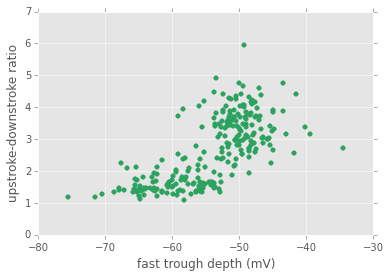

In [21]:
updown = np.array([f['upstroke_downstroke_ratio_short_square'] for f in features], dtype=float)
fasttrough = np.array([f['fast_trough_v_long_square'] for f in features], dtype=float)

plt.figure()
plt.scatter(fasttrough, updown, color='#2ca25f')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")

Note that the data arrives as Unicode strings, so we converted them to floating point numbers.

Let's use numpy to fit a regression line to these data and plot it.

First 5 rows of A:
[[-51.40625      1.        ]
 [-64.28125763   1.        ]
 [-59.09375      1.        ]
 [-44.96875      1.        ]
 [-51.59375      1.        ]]
m 0.107924372039 c 8.48403250554


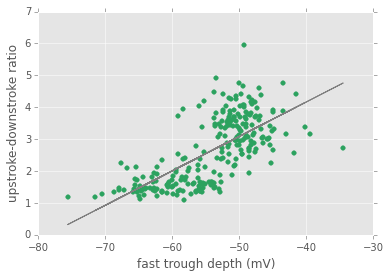

In [22]:
A = np.vstack([fasttrough, np.ones_like(updown)]).T
print "First 5 rows of A:"
print A[:5, :]

m, c = np.linalg.lstsq(A, updown)[0]
print "m", m, "c", c

plt.figure()
plt.scatter(fasttrough, updown, color='#2ca25f')
plt.plot(fasttrough, m * fasttrough + c, c='gray')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")

It looks like there may be roughly two clusters in the data above. Maybe they relate to whether the cells are presumably excitatory (spiny) cells or inhibitory (aspiny) cells. Let's query the data to split up the two sets to see.

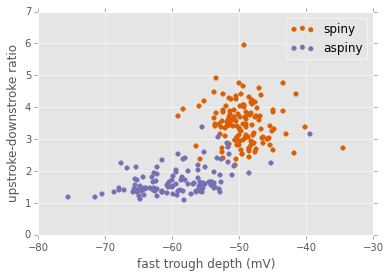

In [25]:
cells = cta.list_cells()

cell_index = { c['id']: c for c in cells}

dendrite_types = ['spiny', 'aspiny']
data = {}

for dendrite_type in dendrite_types:
    type_features = [f for f in features if cell_index[f['specimen_id']]['dendrite_type'] == dendrite_type]
    data[dendrite_type] = {
        "fasttrough": [f['fast_trough_v_long_square'] for f in type_features],
        "updown": [f['upstroke_downstroke_ratio_short_square'] for f in type_features],
    }
    
plt.figure()
for a_type, color in zip(dendrite_types, ["#d95f02", "#7570b3"]):
    plt.scatter(data[a_type]['fasttrough'], data[a_type]['updown'], color=color, label=a_type)
plt.legend(loc='best')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")